In [144]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)


# Experiment ? - Deepseek-R1-7b (Qwen-based)

In this experiment I feed the the model a revisioned version of the input, where the STSG is put the beginning of the prompt and the question with the alternatives at the end. Finally I ask the model to reason about the possible answer *step by step*, conditioning it to perform Zero-Shot-CoT (Prompt engineering technique where no example of thow to perform the reasoning is provided -- no in-context learning). Moreover, instead of asking the model to provide the answer on the same promtp, I instatied the model in multi-turn chat mode where, after the model gives the first response, a script sends an automatic reply asking to extract the final answer given by the model and give it a json format.

**Parameters:**
- model: Gemma3 12b
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


## Prompts

In [145]:
with open('../data/prompts/zero-shot-cot/MCQ_system_prompt_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


You need to respond to reasoning questions by making logical inference on sequence of Scene-Graphs extracted from frames belonging to a video, called a Spatio-Temporal Scene Graph.

IMPORTANT CLARIFICATIONS:
- You will receive a question and Spatio-Temporal Scene-Graph
- Each Scene-Graph is a static symbolic representation of the scene unfolding in the frame
- The Scene-Graphs are ordered chronologically
- The Scene-Graph is represented as a set of tuple in the format: subject - relationship - object
- The Spatio-Temporal Scene-Graph is a cornologically sorted list of Scene-Graphs

INSTRUCTIONS:
- Read the entire Spatio-Temporal Scene-Graphs in chronological order and pay attention at the order of how events unfold.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determing the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.


In [146]:
with open('../data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v2.txt', 'r') as f:
    pr = f.read()

print(pr)


Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:

<STSG>
{stsg}
</STSG>

Given the following question:
<Q>
{question}
<Q>

And the following alternatives:
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>

Provide an answer to the above question reasoning step by step on the Spatio-Temporal Scene-Graph (STSG) and choosing one of the alternatives.


In [147]:
reply = """\
Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\
"""

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [ ]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


## Loading predicted answers evaluation

In [149]:
predictions = []
with open('../outputs/responses_deepseek-r1:7b_20250404_10:41:00.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': ""Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': ""Please carefully..."


In [150]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully..."


In [151]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [152]:
predictions_df['answer'].iloc[0:5] 


id
Interaction_T1_13    <think>\nAlright, so I need to figure out whic...
Interaction_T1_14    <think>\nAlright, so I'm trying to figure out ...
Interaction_T1_31    <think>\nAlright, so I need to figure out whic...
Interaction_T1_32    <think>\nAlright, so I need to figure out whic...
Interaction_T1_40    <think>\nAlright, so I need to figure out whic...
Name: answer, dtype: object

In [153]:

# Create mask for answers that follow JSON syntax
re_pattern = r'^(?:<think>.*(?:</think>)?)\s+({[^}]+})(\s+)?$'
json_mask = predictions_df['answer'].str.match(re_pattern, flags=re.DOTALL)
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 7098
Answers following JSON template: 6378
Percentage following JSON template: 89.86%


In [154]:
predictions_df.loc[~json_mask, 'answer']


id
Interaction_T1_14      <think>\nAlright, so I'm trying to figure out ...
Interaction_T1_81      <think>\nAlright, so I need to figure out whic...
Interaction_T1_139     <think>\nAlright, so I need to figure out whic...
Interaction_T1_210     <think>\nAlright, so I'm trying to figure out ...
Interaction_T1_238     <think>\nAlright, so I need to figure out whic...
                                             ...                        
Feasibility_T6_1327    <think>\nAlright, so I need to figure out what...
Feasibility_T6_1405    <think>\nAlright, so I need to figure out what...
Feasibility_T6_1449    <think>\nAlright, so I'm trying to figure out ...
Feasibility_T6_1454    <think>\nAlright, so I need to figure out what...
Feasibility_T6_1468    <think>\nAlright, so I need to figure out what...
Name: answer, Length: 720, dtype: object

In [155]:
neg_test = predictions_df.loc[~json_mask, 'answer'].loc['Interaction_T1_14']

neg_test


'<think>\nAlright, so I\'m trying to figure out which object was tidied up by the person based on the given STSG data and the alternatives provided.\n\nFirst, I need to understand what an STSG is. From what I remember, it\'s a way to represent spatial-temporal relationships between objects in a scene. It uses nodes for objects and edges for their interactions or positions relative to each other. So, the data inside the <STSG> tags are these nodes and edges that describe how different things are positioned around a person.\n\nLooking at the question: "Which object was tidied up by the person?" The alternatives are A. The blanket, B. The table, C. The clothes, D. The closet/cabinet.\n\nI think "tidied up" implies that someone has cleaned or organized something, so it\'s likely an item that\'s been moved to a specific place, maybe away from where it was before. So I\'m looking for an object that the person has moved to a particular location, possibly putting things away neatly.\n\nNow, le

In [156]:
predictions_df.loc[~json_mask, 'chat_history'].loc['Interaction_T1_14']


[{'role': 'user',
  'content': "Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:\n\n<STSG>\n[['person - holding - towel', 'person - in_front_of - towel', 'person - holding - clothes', 'person - in_front_of - clothes', 'person - holding - blanket', 'person - in_front_of - blanket'], ['person - holding - towel', 'person - in_front_of - towel', 'person - holding - clothes', 'person - in_front_of - clothes', 'person - in_front_of - blanket', 'person - on_the_side_of - blanket'], ['person - holding - towel', 'person - in_front_of - towel', 'person - holding - clothes', 'person - in_front_of - clothes', 'person - in_front_of - blanket'], ['person - holding - clothes', 'person - in_front_of - clothes'], ['person - in_front_of - towel', 'person - holding - clothes', 'person - in_front_of - clothes', 'person - holding - blanket', 'person - in_front_of - blanket'], ['person - in_front_of - clothes', 'person 

In [157]:
# re.match(re_pattern, neg_test, flags=re.DOTALL)[1]


In [158]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(re_pattern, x, flags=re.DOTALL).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Interaction_T1_13        {"answer": "B. The blanket."}
Interaction_T1_14                                     
Interaction_T1_31        {"answer": "C. The clothes."}
Interaction_T1_32           {"answer": "B. The shoe."}
Interaction_T1_40         {"answer": "C. The blanket"}
                                    ...               
Feasibility_T6_1453     {"answer": "D. Open the bag."}
Feasibility_T6_1454                                   
Feasibility_T6_1455    {"answer": "D. Take the shoe."}
Feasibility_T6_1456     {"answer": "A. Hold the food"}
Feasibility_T6_1468                                   
Name: answer, Length: 7098, dtype: object

In [159]:
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [160]:
predictions_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7098 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   chat_history  7098 non-null   object
 1   answer        7098 non-null   object
dtypes: object(2)
memory usage: 424.4+ KB


In [161]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


,chat_history,answer
id,,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully...",B. The blanket.
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully...",
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully...",C. The clothes.
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully...",B. The shoe.
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully...",C. The blanket
...,...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully...",D. Open the bag.
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully...",
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully...",D. Take the shoe.


In [162]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 5987
84.35% of the total

Only 1111 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_2735/4018721229.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [163]:
predictions_df.loc[~contains_answer, 'answer']


id
Interaction_T1_14                                                       
Interaction_T1_70      None of the alternatives are supported by the ...
Interaction_T1_81                                                       
Interaction_T1_106          No object is thrown based on the given data.
Interaction_T1_139                                                      
                                             ...                        
Feasibility_T6_1412    There is insufficient information provided in ...
Feasibility_T6_1414    None of the alternatives can be confirmed as c...
Feasibility_T6_1449                                                     
Feasibility_T6_1454                                                     
Feasibility_T6_1468                                                     
Name: answer, Length: 1111, dtype: object

## Extract answers

In [164]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The blanket.
Interaction_T1_31,The clothes.
Interaction_T1_32,The shoe.
Interaction_T1_40,The blanket.
Interaction_T1_43,The clothes.
...,...
Feasibility_T6_1430,Wash the dish.
Feasibility_T6_1448,Put down the laptop.
Feasibility_T6_1453,Open the bag.


In [165]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5987 entries, Interaction_T1_13 to Feasibility_T6_1456
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5987 non-null   object
dtypes: object(1)
memory usage: 93.5+ KB


In [166]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 498 unique answers


In [167]:
ans_df['text'].value_counts()


text
Put down.                            601
Took.                                237
The towel.                           194
The bag.                             181
The clothes.                         154
                                    ... 
Threw the book.                        1
Throwing the towel.                    1
Washed the mirror.                     1
Tidied up the closet/cabinets.         1
The person is holding the laptop.      1
Name: count, Length: 249, dtype: int64

<Axes: xlabel='freq', ylabel='word'>

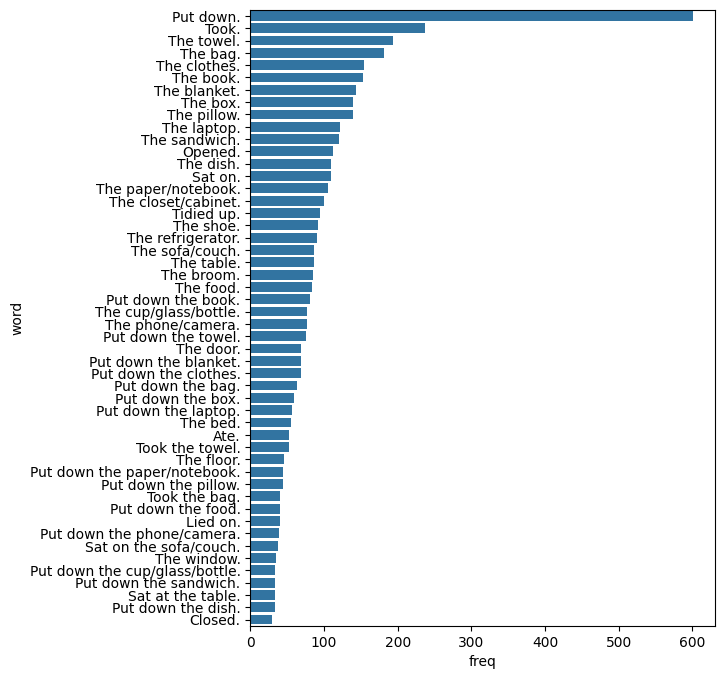

In [168]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [169]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


<Axes: xlabel='freq', ylabel='word'>

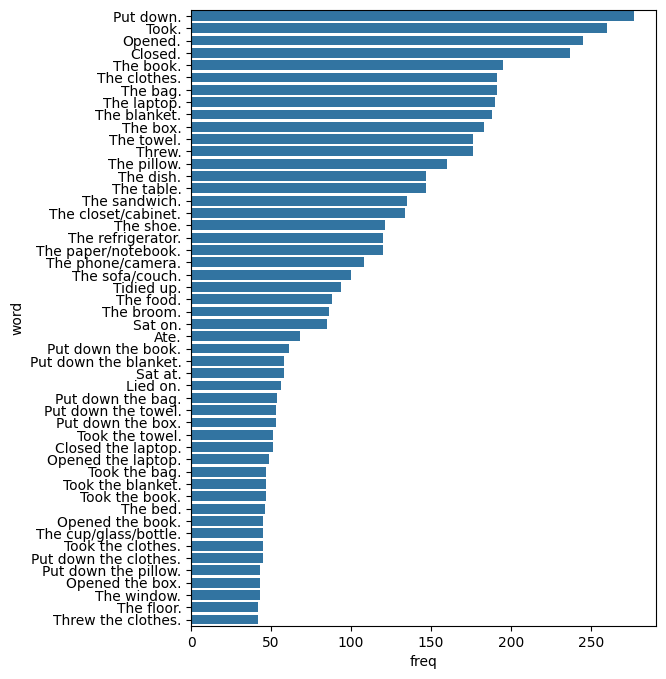

In [170]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [171]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(5987, 5)

In [172]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


check if the equality with NA result in a false or is skipped

In [173]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 54.40%


In [174]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [175]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1997        60.89%  
Sequence            3064        66.25%  
Prediction           528        68.18%  
Feasibility          398        64.07%  


In [176]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        83.28%  
Sequence            3586        85.44%  
Prediction           624        84.62%  
Feasibility          490        81.22%  
Overall             7098        84.35%  
